<!--
 Copyright 2025 beedi.goua_square-ma
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [43]:
# Activation du rechargement automatique (utile pour développement en local)
%load_ext autoreload
%autoreload 2

# mports de base 
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Affichage interactif
from IPython.display import display

# Configuration des chemins 
base_dir = Path().resolve().parent
inputs_dir = base_dir / "data"
notebook_dir = base_dir / "notebooks"
src_dir = base_dir / "src"
model_dir = base_dir / "models"

for directory in [base_dir, inputs_dir, notebook_dir, src_dir, model_dir]:
    directory.mkdir(parents=True, exist_ok=True)
    sys.path.insert(0, str(directory.resolve()))


In [45]:

# ML / NLP / Project imports 
from sklearn.metrics import classification_report

from src.models.train_model import train_model_pipeline, save_artifacts, get_model

from src.models.evaluate_model import evaluate_classifier,evaluate_model_with_features
from src.models.utils import (
    load_preprocessed_dataset,
    show_misclassified_examples,
    plot_top_features,
    load_model
)


In [46]:
# Fichiers d'entrée 
PATH_BALANCED = inputs_dir / "processed/balanced_reviews.csv"
PATH_ENRICHED = inputs_dir / "processed/enriched_reviews.csv"

# Colonnes principales 
TEXT_COL = "text_clean"
LABEL_COL = "label_toxic"


## Chargement des données

In [47]:
df_train = load_preprocessed_dataset(PATH_BALANCED)
df_eval = load_preprocessed_dataset(PATH_ENRICHED)

print(f"Jeu d'entraînement équilibré : {df_train.shape}")
print(f"Jeu d'évaluation déséquilibré : {df_eval.shape}")


INFO:src.models.utils:7296 lignes chargées depuis C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\ReviewGuardian\data\processed\balanced_reviews.csv
INFO:src.models.utils:14957 lignes chargées depuis C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\ReviewGuardian\data\processed\enriched_reviews.csv


Jeu d'entraînement équilibré : (7296, 31)
Jeu d'évaluation déséquilibré : (14957, 31)


## Définition des features


In [48]:
feature_cols = [
    "flesch_score", "sentiment_polarity", "nb_exclamations",
    "has_url", "has_email", "has_phone", "has_emoji", "capital_ratio"
]


## Entraînement & comparaison multi-modèles



In [49]:
from sklearn.model_selection import train_test_split
from src.models.utils import load_model
from IPython.display import display
import pandas as pd

# Configuration
models_to_test = {
    "logreg": "logreg_toxic",
    "rf": "rf_toxic",
    "nb": "nb_toxic"
}

all_scores = []

# Split manuel pour stabilité
X_text = df_train[TEXT_COL]
y = df_train[LABEL_COL]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)
df_train_split = df_train.loc[X_train_text.index]
df_test_split = df_train.loc[X_test_text.index]

# Entraînement et évaluation
for model_key, model_name in models_to_test.items():
    print(f"\nEntraînement modèle : {model_key.upper()}")

    try:
        pipeline, bundle, metrics = train_model_pipeline(
            df=df_train_split,
            text_col=TEXT_COL,
            label_col=LABEL_COL,
            feature_cols=feature_cols,
            model_name=model_key
        )

        # Sauvegarde
        save_artifacts(
            model=pipeline,
            metrics=metrics,
            output_dir="models",
            model_name=model_name,
            versioning=False
        )

        # Évaluation sur split test (texte brut)
        
        evaluate_model_with_features(
            model_path=f"models/{model_name}.pkl",
            df_test=df_test_split,
            text_col=TEXT_COL,
            label_col=LABEL_COL,
            feature_cols=feature_cols,
            model_name=model_name
        )


        metrics["model"] = model_key
        all_scores.append(metrics)
        df_scores = pd.DataFrame(all_scores)
        df_scores.to_csv("reports/model_comparison.csv", index=False)


    except Exception as e:
        print(f"Erreur pour le modèle {model_key}: {e}")


INFO:src.models.train_model:Entraînement pipeline pour modèle `logreg`
INFO:src.models.train_model:Vectorisation avec TF-IDF



Entraînement modèle : LOGREG


INFO:src.models.train_model:Fusion avec variables enrichies...
INFO:src.models.train_model:Split train/test...
INFO:src.models.train_model:Taille du train : (4668, 10008), test : (1168, 10008)
INFO:src.models.train_model:Entraînement en cours...
INFO:src.models.train_model:Scores : {'accuracy': 0.8167808219178082, 'precision': 0.8083333333333333, 'recall': 0.8304794520547946, 'f1_score': 0.8192567567567568, 'roc_auc': np.float64(0.9041623662976168)}
INFO:models.utils:Modèle sauvegardé → models\logreg_toxic.pkl
INFO:src.models.train_model:Modèle sauvegardé : models\logreg_toxic.pkl
INFO:src.models.train_model:Métriques sauvegardées : models\logreg_toxic_metrics.json
INFO:models.utils:Chargement modèle → models/logreg_toxic.pkl
INFO:src.models.evaluate_model:Rapport complet généré pour logreg_toxic
INFO:src.models.train_model:Entraînement pipeline pour modèle `rf`
INFO:src.models.train_model:Vectorisation avec TF-IDF



Entraînement modèle : RF


INFO:src.models.train_model:Fusion avec variables enrichies...
INFO:src.models.train_model:Split train/test...
INFO:src.models.train_model:Taille du train : (4668, 10008), test : (1168, 10008)
INFO:src.models.train_model:Entraînement en cours...
INFO:src.models.train_model:Scores : {'accuracy': 0.853595890410959, 'precision': 0.8211508553654744, 'recall': 0.9041095890410958, 'f1_score': 0.8606356968215159, 'roc_auc': np.float64(0.9236401060236441)}
INFO:models.utils:Modèle sauvegardé → models\rf_toxic.pkl
INFO:src.models.train_model:Modèle sauvegardé : models\rf_toxic.pkl
INFO:src.models.train_model:Métriques sauvegardées : models\rf_toxic_metrics.json
INFO:models.utils:Chargement modèle → models/rf_toxic.pkl
INFO:src.models.evaluate_model:Rapport complet généré pour rf_toxic
INFO:src.models.train_model:Entraînement pipeline pour modèle `nb`
INFO:src.models.train_model:Vectorisation avec CountVectorizer



Entraînement modèle : NB


INFO:src.models.train_model:Fusion avec variables enrichies...
INFO:src.models.train_model:Forçage des valeurs positives (MultinomialNB)
INFO:src.models.train_model:Split train/test...
INFO:src.models.train_model:Taille du train : (4668, 10008), test : (1168, 10008)
INFO:src.models.train_model:Entraînement en cours...
INFO:src.models.train_model:Scores : {'accuracy': 0.7303082191780822, 'precision': 0.71658615136876, 'recall': 0.761986301369863, 'f1_score': 0.7385892116182573, 'roc_auc': np.float64(0.7952286428035279)}
INFO:models.utils:Modèle sauvegardé → models\nb_toxic.pkl
INFO:src.models.train_model:Modèle sauvegardé : models\nb_toxic.pkl
INFO:src.models.train_model:Métriques sauvegardées : models\nb_toxic_metrics.json
INFO:models.utils:Chargement modèle → models/nb_toxic.pkl
INFO:src.models.evaluate_model:Rapport complet généré pour nb_toxic


## Résumé des performances in-sample


In [50]:
df_scores = pd.DataFrame(all_scores).set_index("model")
display(df_scores.style.background_gradient(cmap="YlGnBu").format("{:.3f}"))


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
logreg,0.817,0.808,0.830,0.819,0.904
rf,0.854,0.821,0.904,0.861,0.924
nb,0.730,0.717,0.762,0.739,0.795


## Test final (out-of-sample) sur df_enriched


In [51]:
y_true = df_eval[LABEL_COL]
X_text = df_eval[TEXT_COL]
X_feat = df_eval[feature_cols] if feature_cols else None

from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

for model_key, model_name in models_to_test.items():
    print(f"\nÉvaluation finale modèle : {model_key.upper()}")

    model = load_model(f"models/{model_name}.pkl")
    vectorizer = model.named_steps["vectorizer"]
    classifier = model.named_steps["classifier"]
    
    # Vectorisation du texte
    X_text_vec = vectorizer.transform(X_text)

    if X_feat is not None:
        # CORRECTION: Convertir les features en float64 et gérer les valeurs manquantes
        X_feat_clean = X_feat.astype('float64')
        X_feat_clean = X_feat_clean.fillna(0)  # Remplacer NaN par 0
        
        # Convertir en matrice sparse si nécessaire
        from scipy.sparse import csr_matrix
        X_feat_sparse = csr_matrix(X_feat_clean.values)
        
        X_final = hstack([X_text_vec, X_feat_sparse])
    else:
        X_final = X_text_vec

    # CORRECTION: Utiliser directement le classifier au lieu d'evaluate_classifier
    # car nous avons déjà des données vectorisées
    y_pred = classifier.predict(X_final)
    y_proba = classifier.predict_proba(X_final)[:, 1] if hasattr(classifier, 'predict_proba') else None
    
    # Calculer les métriques manuellement
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"  ROC-AUC: {roc_auc:.4f}")
    
    # Sauvegarder les métriques
    import json
    import os
    os.makedirs("reports", exist_ok=True)
    
    final_metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }
    
    with open(f"reports/{model_name}_final_metrics.json", "w") as f:
        json.dump(final_metrics, f, indent=2)

INFO:src.models.utils:Chargement modèle → models/logreg_toxic.pkl



Évaluation finale modèle : LOGREG


INFO:src.models.utils:Chargement modèle → models/rf_toxic.pkl


  Accuracy: 0.8410
  Precision: 0.6240
  Recall: 0.8761
  F1-Score: 0.7288
  ROC-AUC: 0.9266

Évaluation finale modèle : RF


INFO:src.models.utils:Chargement modèle → models/nb_toxic.pkl


  Accuracy: 0.8766
  Precision: 0.6717
  Recall: 0.9660
  F1-Score: 0.7924
  ROC-AUC: 0.9772

Évaluation finale modèle : NB
  Accuracy: 0.6619
  Precision: 0.3998
  Recall: 0.7706
  F1-Score: 0.5265
  ROC-AUC: 0.7548


## Analyse d'interprétabilité (pour LogReg uniquement)


In [52]:
# Mots les plus "toxiques"

logreg_model = load_model("models/logreg_toxic.pkl")



INFO:src.models.utils:Chargement modèle → models/logreg_toxic.pkl


In [53]:
logreg_model

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english',
                                 strip_accents='unicode')),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

Attention : nombre de coefficients (10008) â‰  nombre de features (10000).
Mots les plus influents :
garbage              5.9764
terrible             5.9731
hate                 5.6995
awful                5.0421
stupid               4.9825
trash                4.4434
bad                  4.3857
suck                 3.7923
crap                 3.6816
dumb                 2.9882
movie                2.5104
screw                2.0991
damn                 2.0155
ve                   2.0135
bad book             1.9908
good                 1.9466
worst                1.9109
bad movie            1.8966
maybe                1.8062
band                 1.7045


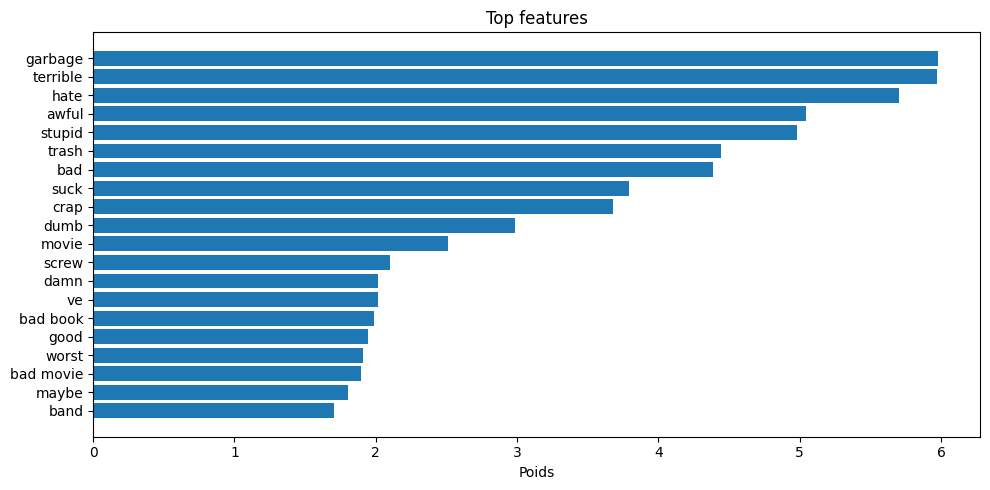

In [54]:
plot_top_features(
    vectorizer=logreg_model.named_steps["vectorizer"],
    model=logreg_model.named_steps["classifier"],
    top_n=20
)


##  Analyse qualitative des erreurs


In [57]:
vectorizer = model.named_steps["vectorizer"]
classifier = model.named_steps["classifier"]
X_text_vec = vectorizer.transform(X_text)

X_feat_clean = X_feat.astype('float64').fillna(0)
X_feat_sparse = csr_matrix(X_feat_clean.values)
X_final = hstack([X_text_vec, X_feat_sparse])
y_pred = classifier.predict(X_final)


In [58]:
# Étape 5 : Probabilités si disponible
y_proba = classifier.predict_proba(X_final)[:, 1] if hasattr(classifier, 'predict_proba') else None

# Étape 6 : Évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

print("Évaluation du modèle :")
print(f"  Accuracy : {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1-score : {f1:.4f}")
if roc_auc is not None:
    print(f"  ROC-AUC  : {roc_auc:.4f}")


Évaluation du modèle :
  Accuracy : 0.6619
  Precision: 0.3998
  Recall   : 0.7706
  F1-score : 0.5265
  ROC-AUC  : 0.7548


In [ ]:
import numpy as np

def show_misclassified_examples(X_raw, y_true, y_pred, n=5, random_state=None):
    """
    Affiche n exemples aléatoires parmi les exemples mal classés.
    
    Args:
        X_raw : Série ou liste des textes initiaux
        y_true : Étiquettes vraies
        y_pred : Prédictions
        n : Nombre d’exemples à afficher
        random_state : Entier pour reproductibilité (optionnel)
    """
    misclassified_idx = np.where(y_true != y_pred)[0]

    if len(misclassified_idx) == 0:
        print("Aucun exemple mal classé !")
        return

    # Tirage aléatoire d'indices
    rng = np.random.default_rng(random_state)
    sampled_idx = rng.choice(misclassified_idx, size=min(n, len(misclassified_idx)), replace=False)

    print(f"\nExemples mal classés (aléatoires) :")
    for i, idx in enumerate(sampled_idx, 1):
        text = X_raw.iloc[idx] if hasattr(X_raw, "iloc") else X_raw[idx]
        true = y_true.iloc[idx] if hasattr(y_true, "iloc") else y_true[idx]
        pred = y_pred[idx]
        print(f"\n--- Exemple {i} ---")
        print(f"Texte    : {text[:300]}...")
        print(f"Vérité   : {true}")
        print(f"Prédit   : {pred}")


In [66]:
show_misclassified_examples(X_text, y_true, y_pred, n=5)



Exemples mal classés (n=5) :

--- Exemple 1 ---
Texte    : sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play good music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen...
Vérité   : 1
Prédit   : 0

--- Exemple 2 ---
Texte    : soundtrack favorite music time hand intense sadness prisoner fate mean you ve play game hope distant promise girl steal star important inspiration personally throughout teen year high energy track like chrono cross times scar time dreamwatch chronomantique indefinably remeniscent chrono trigger abso...
Vérité   : 0
Prédit   : 1

--- Exemple 3 ---
Texte    : truly like soundtrack enjoy video game music play game music enjoy truly relax peacefulon disk one favorite scar time life death forest illusion fortress ancient dragon lose fragment drown valleydisk two draggon galdorb home chronomantique prisoner fate gale girlfriend 

In [67]:
import numpy as np

def show_correctly_classified_examples(X_raw, y_true, y_pred, n=5, random_state=None):
    """
    Affiche n exemples aléatoires parmi les exemples bien classés.
    
    Args:
        X_raw : Série ou liste des textes initiaux
        y_true : Étiquettes vraies
        y_pred : Prédictions
        n : Nombre d’exemples à afficher
        random_state : Entier pour reproductibilité (optionnel)
    """
    correctly_idx = np.where(y_true == y_pred)[0]

    if len(correctly_idx) == 0:
        print("Aucun exemple bien classé.")
        return

    rng = np.random.default_rng(random_state)
    sampled_idx = rng.choice(correctly_idx, size=min(n, len(correctly_idx)), replace=False)

    print(f"\nExemples bien classés (aléatoires) :")
    for i, idx in enumerate(sampled_idx, 1):
        text = X_raw.iloc[idx] if hasattr(X_raw, "iloc") else X_raw[idx]
        true = y_true.iloc[idx] if hasattr(y_true, "iloc") else y_true[idx]
        pred = y_pred[idx]
        print(f"\n--- Exemple {i} ---")
        print(f"Texte    : {text[:300]}...")
        print(f"Vérité   : {true}")
        print(f"Prédit   : {pred}")


In [68]:
show_correctly_classified_examples(X_text, y_true, y_pred, n=5)



Exemples bien classés (aléatoires) :

--- Exemple 1 ---
Texte    : really want like book good friend suggest decide give go big mistake book put sleep literally description land plant life go forever take way long get plot worth time...
Vérité   : 0
Prédit   : 0

--- Exemple 2 ---
Texte    : buy christmas light outside one treework great even every remote turn offand drive crazythe car remote garage handy switch turn light...
Vérité   : 0
Prédit   : 0

--- Exemple 3 ---
Texte    : two year get first song decent rapreggae guy vocal thang rdjs music behind background except first second music exceptional nice crazy dnb stuff vocal song worth get two track noise hooked electrode recording equipment twiddled knob something maybe real song encrypt know music they re likely sick jo...
Vérité   : 0
Prédit   : 0

--- Exemple 4 ---
Texte    : do not let bad cover art fool see theater buy immediately come dvd powerful film say give away...
Vérité   : 0
Prédit   : 0

--- Exemple 5 ---
Texte    :